/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:117: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


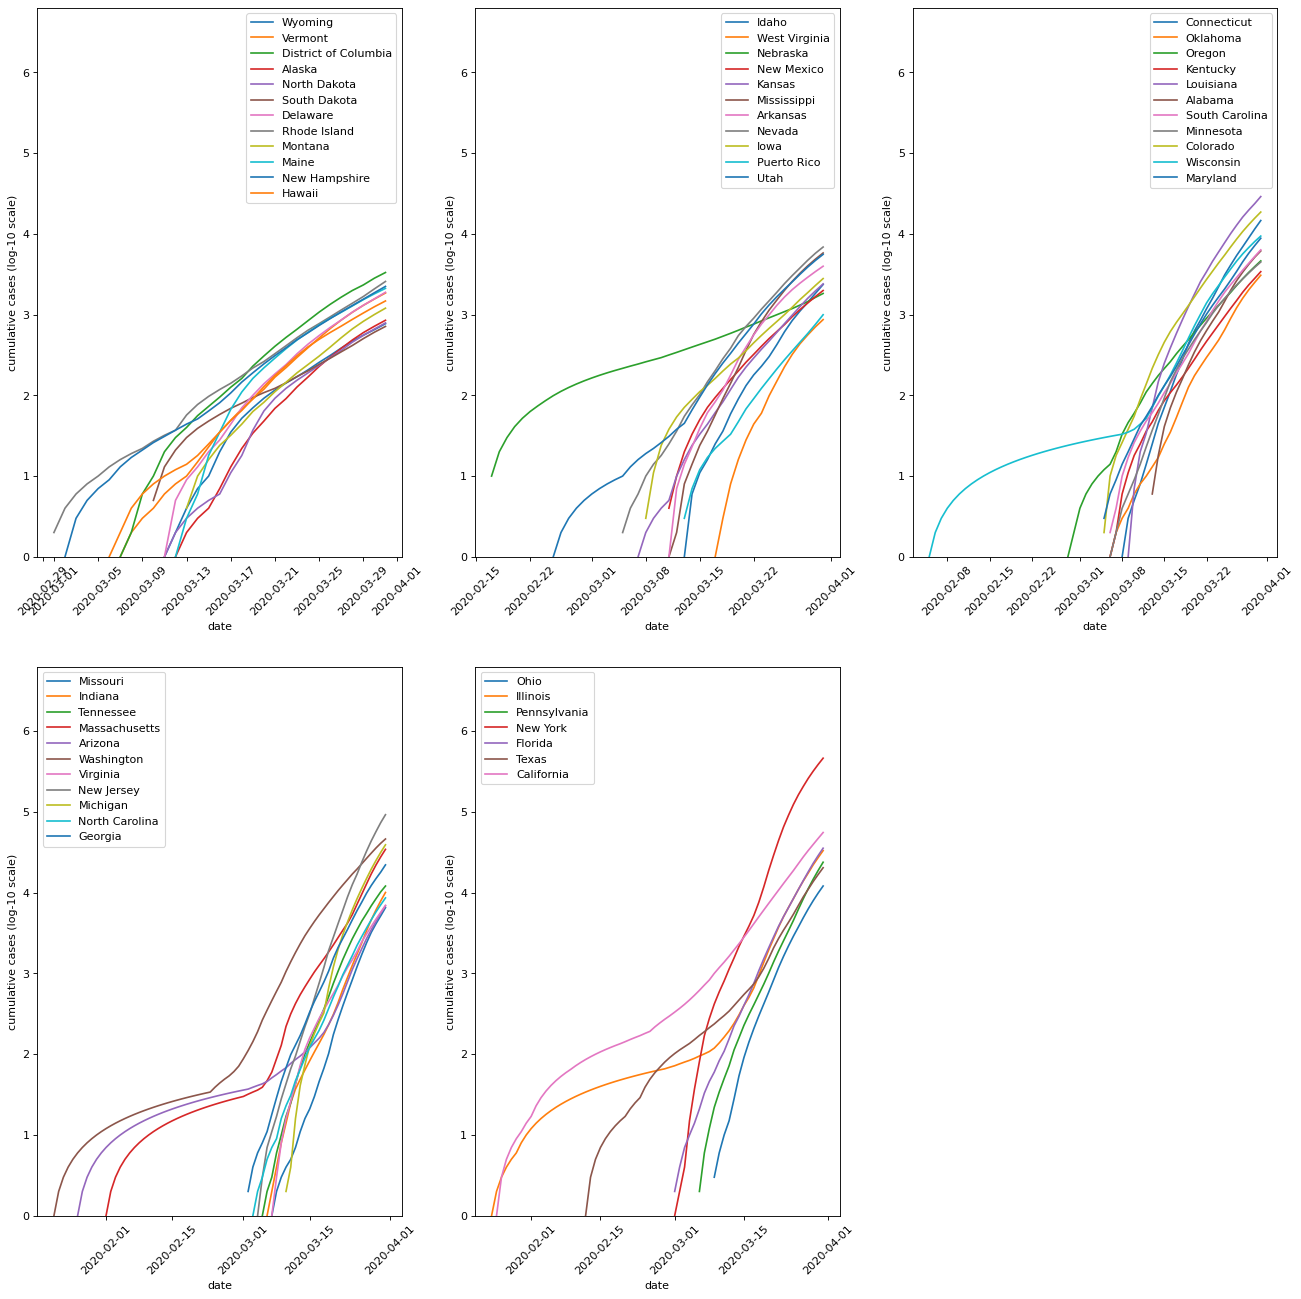

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  1 10:09:24 2020

@author: Matthew
"""

import requests, pandas, io, numpy as np, datetime, matplotlib.pyplot as plt

#%%settings
#param? "cases" or "deaths"
interest="cases"
#normalize by population?
norm=False
#log scale?
log_scale=True
#show state population in legend?
leg_pop=False
#how many graphs?
n=5



#%%setup
##set scale
#if interest=="cases":
#    ylimit=.025
#else:
#    ylimit=.00035
    


#%matplotlib qt
plt.close("all")
#get covid info
r=requests.get("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
cov_sheet=io.StringIO(r.text)
cov_sheet=pandas.read_csv(cov_sheet)
cov_sheet=cov_sheet.sort_values(by="state")
#get state pop info
#pop_sheet=pandas.read_excel('nst-est2019-01.xlsx')
response=requests.get("https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx?#")
bytes_file_obj = io.BytesIO()
bytes_file_obj.write(response.content)
bytes_file_obj.seek(0) #set file object to start

#read file into pandas dataframe
pop_sheet = pandas.read_excel(bytes_file_obj)

#deal with state sheet
state_names=np.asarray(pop_sheet.iloc[8:59,0]).astype(str)
state_pops=np.asarray(pop_sheet.iloc[8:59,12]).astype(int)
state_names=np.asarray([e[1:] for e in state_names])
state_names=np.append(state_names,'Puerto Rico')
state_pops=np.append(state_pops,3193694)
#sort states by population
bypop=np.argsort(state_pops)
state_pops=state_pops[bypop]
state_names=state_names[bypop]

statesper=np.ceil(len(state_names)/n)#states per graph
labelstring="cumulative " + interest + norm*" per population" +log_scale*" (log-10 scale)"
subind=1
these_states=[] #variable keeps state names by plot for the legend
plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
most=0
for i in range(len(state_names)):
    #if starting new subgraph, set the subplot
    if len(these_states)==0:
        plt.subplot(2,np.ceil(n/2),subind)
    
    state=state_names[i]
    pop=state_pops[i]
    if leg_pop:
        these_states.append(state + " (population = " + str(int(pop/100000)/10) +" million)")
    else:
        these_states.append(state)
        
    #get only this date's info
    cov_state=cov_sheet[cov_sheet.state==state]
    #sort by date to get proper order
    cov_state=cov_state.sort_values("date")
    dates=np.asarray(cov_state["date"])
    #convert from string to datetime format
    dates=np.asarray([datetime.date(int(e[:4]),int(e[5:7]),int(e[8:])) for e in dates])
    #take parameter of interest. can either be cases or deaths
    to_plot=np.cumsum(np.asarray(cov_state[interest]))
    #do we want to normalize
    if norm:
        to_plot=to_plot/pop
    if log_scale:
        to_plot=np.log10(to_plot)
        
    plt.plot(dates,(to_plot))
    
    most=np.max([most,np.max(to_plot)])
    
    if ((i%(statesper) == 0) & (i!=0)):
        plt.legend(np.asarray(these_states))
        plt.xlabel("date")
        plt.ylabel(labelstring)
        plt.xticks(rotation=45)
        #plt.ylim((0,ylimit))
        these_states=[]
        subind+=1
        
    
if len(these_states)!=0:
        plt.legend(np.asarray(these_states))
        plt.xlabel("date")
        plt.xticks(rotation=45)
        plt.ylabel(labelstring)
        #plt.ylim((0,ylimit))
        
for i in range(n):
    i=i+1
    ax=plt.subplot(2,np.ceil(n/2),i)    
    ax.set_ylim([0, most*1.2])
    ax.set_xlim(left=datetime.date(2020,3,1))
